# Formative 2: Hate Speech Detection

In [ ]:
# Load relevant packages

import pandas as pd
import numpy as np
import re
import csv
import operator
import random
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

## 1) Preparing and describing the dataset
For this Formative, we are working with a dataset labelled for hate and abuse by Founta et al. (2018).

#### 1a) Load the tweets
Using pandas, load the .csv dataset for Formative 2 to a dataframe called *df*.

In [ ]:
df = pd.read_csv("./0_data/founta2018_formative2.csv")

Inspect a random sample of 10 tweets in the dataset to get an idea of the kind of content you will be working with.

In [ ]:
df.head(10)

,tweet,label
0,Beats by Dr. Dre urBeats Wired In-Ear Headphones - White https://t.co/9tREpqfyW4 https://t.co/FCaWyWRbpE,spam
1,RT @Papapishu: Man it would fucking rule if we had a party that was against perpetual warfare.,abusive
2,"It is time to draw close to Him 🙏🏻 Father, I draw near to you now and always ❤️ https://t.co/MVRBBX2aqJ",normal
3,if you notice me start to act different or distant.. it's bc i peeped something you did or i notice a difference in how you act & ian fw it.,normal
4,"Forget unfollowers, I believe in growing. 7 new followers in the last day! Stats via https://t.co/bunPHQNXhj",normal
5,RT @Vitiligoprince: Hate Being sexually Frustrated Like I wanna Fuck But ion wanna Just fuck anybody,abusive
6,Topped the group in TGP Disc Jam Season 2! Onto the Semi-Finals! @HighHorseGames https://t.co/N7LE8lX7Rm,normal
7,That daily baby aspirin for your #heart just might be preventing colon #cancer too. https://t.co/2TLawmHhEe,normal
8,I liked a @YouTube video from @mattshea https://t.co/niSeJrLKHq THE BLUE ARMY IS COMING! - Ancient Warfare 2,normal
9,"RT @LestuhGang_: If your fucking up & your homies dont tell you that your fucking up, those ain't your homies",abusive


#### 1b) Clean the tweets
User-generated content on social media is messy, and has many artefacts that might throw off statistical analyses. Some data cleaning is almost always necessary.<br>
Here is a function written for data cleaning. Regex replaces mentions (like "@Paul") with "USR" and URLs (starting with "http") with "URL". Newline and tab characters ("\n" and "\t") were removed. Excess whitespace at the beginning and end of tweets were stipped. All text was lowercased.

In [ ]:
def clean_text(text):

    # replace mentions and URLs with special token --> provide to students
    text = re.sub(r"@[A-Za-z0-9_-]+",'USR',text)
    text = re.sub(r"http\S+",'URL',text)

    # remove newline and tab characters
    text = re.sub(r"[\n\t]*", "", text)

    # strip whitespace
    text = text.strip()

    # lowercase
    text = text.lower()

    return text

In [ ]:
df['tweet'] = df['tweet'].apply(clean_text)

#### 1c) Investigate duplicates
This dataset has quite a few duplicate entries: 1) full duplicates, where tweet and label are the same, plus 2) duplicate tweets that have different labels.

In [ ]:
#Full duplicates
df[df.duplicated()]

,tweet,label
280,rt usr: this fucked me up url,abusive
304,rt usr: this fucked me up url,abusive
393,rt usr: this fucked me up url,abusive
464,usr usr usr usr usr usr usr usr… url,normal
465,"the abc is cutting jobs, remember?. abcnews24 is now just abc news. it's time to kiss u know what for funding for t… url",normal
...,...,...
99957,found a transponder snail! scoop! exclusive photos of the mysterious mr. 0!! url #trecru url,normal
99960,rt usr: this fucked me up url,abusive
99962,it's an all-too-familiar lesson for you archers: more of a goo... more for sagittarius url,normal
99984,rt usr: who all fucking with #littypalooza,abusive


In [ ]:
#Duplicate Tweet
df[df.duplicated(subset = 'tweet')]

,tweet,label
280,rt usr: this fucked me up url,abusive
304,rt usr: this fucked me up url,abusive
333,"you are a force to be reckoned with wherever you go now, and ... more for aries url",normal
393,rt usr: this fucked me up url,abusive
464,usr usr usr usr usr usr usr usr… url,normal
...,...,...
99957,found a transponder snail! scoop! exclusive photos of the mysterious mr. 0!! url #trecru url,normal
99960,rt usr: this fucked me up url,abusive
99962,it's an all-too-familiar lesson for you archers: more of a goo... more for sagittarius url,normal
99984,rt usr: who all fucking with #littypalooza,abusive


**Q:** For each of the two types of duplicates, how would keeping them in the dataset affect our statistical analyses?

**A:** Keeping the first type would skew our model and overrepresent words in duplicated tweets in making classification decisions. Keeping the second type would 'confuse' our model since

#### 1d) Deduplicate the data
Drop duplicate entries, counting the number of tweets before and after dropping them. (*Hint: look into .drop_duplicates() with the "subset" attribute*)

In [ ]:
df.shape

(99996, 2)

In [ ]:
df=df.drop_duplicates(subset='tweet')

In [ ]:
df.shape

(87327, 2)

#### 1e) Make the tweet labels binary
Each tweet in the dataset was originally assigned one of four labels. For this Formative, we only focus on the binary distinction between hateful and non-hateful content.<br>
Collapse the three labels other than "hateful" into a single "non-hateful" label to make the task binary.

In [ ]:
df['label'].value_counts()

normal     50596
abusive    20149
spam       12514
hateful     4068
Name: label, dtype: int64

In [ ]:
df['label'] = df['label'].map({'normal':'non-hateful',
                 'abusive':'non-hateful',
                 'spam':'non-hateful',
                 'hateful':'hateful'})

#### 1f) Describe the class distribution
Describe the relative and absolute class distribution in the data: How many tweets and what percentage of tweets in the dataset are labelled (non-)hateful?

In [ ]:
df['label'].value_counts()

non-hateful    83259
hateful         4068
Name: label, dtype: int64

In [ ]:
df['label'].value_counts(normalize=True)

non-hateful    0.953416
hateful        0.046584
Name: label, dtype: float64

#### 1g) Tweets into lists

We need to split our tweets (single strings) into lists of string tokens.

The regexp selects tokens of 2 or more alphanumeric characters. Punctuation is completely ignored and always treated as a token separator. This is particularly useful for messy text like the tweets we are working with.

In [ ]:
token_pattern = re.compile(r"(?u)\b\w\w+\b")
df["tweet_list"] = df.tweet.apply(lambda x: token_pattern.findall(x))

In [ ]:
df.head(5)

,tweet,label,tweet_list
0,beats by dr. dre urbeats wired in-ear headphones - white url url,non-hateful,"[beats, by, dr, dre, urbeats, wired, in, ear, headphones, white, url, url]"
1,rt usr: man it would fucking rule if we had a party that was against perpetual warfare.,non-hateful,"[rt, usr, man, it, would, fucking, rule, if, we, had, party, that, was, against, perpetual, warfare]"
2,"it is time to draw close to him 🙏🏻 father, i draw near to you now and always ❤️ url",non-hateful,"[it, is, time, to, draw, close, to, him, father, draw, near, to, you, now, and, always, url]"
3,if you notice me start to act different or distant.. it's bc i peeped something you did or i notice a difference in how you act & ian fw it.,non-hateful,"[if, you, notice, me, start, to, act, different, or, distant, it, bc, peeped, something, you, did, or, notice, difference, in, how, you, act, ian, fw, it]"
4,"forget unfollowers, i believe in growing. 7 new followers in the last day! stats via url",non-hateful,"[forget, unfollowers, believe, in, growing, new, followers, in, the, last, day, stats, via, url]"


#### 1h) Split the data into a train, dev and test set

Using the train_test_split function from sklearn, split df.tweet_list into a training, development and test set. Use a 70/15/15 split. Setting a fixed random_state=123, so we get the same splits as all other students.

In [ ]:
X = df['tweet_list'].values
y = df['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

In [ ]:
categories = ["hateful", "non-hateful"]

In [ ]:
train_tweets, dev_tweets, test_tweets = dict(), dict(), dict()

#### 1i) Create vocabularies from training set
Using our train_tweets for this.
The Counter dictionaries should have as their keys the entries in our vocab and as their values the frequency of corresponding entries in in our train_tweets.<br>
Then create Counter dictionaries for each category that count the number of train_tweets a given word appeared in. Those will be needed for calculating mutual information, later in the Formative.<br>
As an example: the word "islam" appears 29 times in the non-hateful train_tweets, and it appears in 27 distinct non-hateful train_tweets.

In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [ ]:
for c_i in categories:
    train_tweets[c_i] = Counter(flatten(X_train[y_train == c_i]))
    dev_tweets[c_i] = Counter(flatten(X_dev[y_dev == c_i]))
    test_tweets[c_i] = Counter(flatten(X_test[y_test == c_i]))

In [ ]:
train_tweets_distinct, dev_tweets_distinct, test_tweets_distinct = dict(), dict(), dict()

for c_i in categories:
    train_tweets_distinct[c_i] = Counter(flatten([list(set(x)) for x in X_train[y_train == c_i]]))
    dev_tweets_distinct[c_i] = Counter(flatten([list(set(x)) for x in X_dev[y_dev == c_i]]))
    test_tweets_distinct[c_i] = Counter(flatten([list(set(x)) for x in X_test[y_test == c_i]]))

**Q:** For each class, how many entries are there in the vocabulary?

In [ ]:
for c_i in categories:
    print(f'{c_i}: {len(train_tweets[c_i])}')

hateful: 8001
non-hateful: 66037


#### 1j) Find the most frequent words in our training set
Find the 10 most common words for each class in our training set and how often they occured.

In [ ]:
for c_i in categories:
    print(f'{c_i}: {train_tweets[c_i].most_common(10)}')

hateful: [('usr', 2349), ('the', 1291), ('url', 1282), ('to', 1004), ('you', 868), ('and', 687), ('rt', 666), ('is', 629), ('of', 577), ('that', 494)]
non-hateful: [('url', 43496), ('usr', 41815), ('the', 24960), ('to', 20611), ('and', 14202), ('you', 14108), ('of', 11384), ('in', 10887), ('for', 9817), ('is', 9816)]


**Q:** What type of words are these? How useful do you think they will be for the classification task?

**A:** Many of them are stopwords and are not useful in distinguishing between hateful and non-hateful speech

#### 1k) Load and inspect stopwords
We use NLTK's stopword list, with added Twitter-specific stopwords such as "rt", "usr" and "url".<br>
Loading the stopwords from the .txt file to a list and showing the first 10 entries.

In [ ]:
stopwords = open("./0_data/stopwords_formative2.txt", "r").read().split('\n')

In [ ]:
stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

#### 1l) Delete stopwords from the vocabularies

In [ ]:
for word in stopwords:
    if word in train_tweets['hateful']: del train_tweets['hateful'][word]
    if word in train_tweets['non-hateful']: del train_tweets['non-hateful'][word]

    if word in train_tweets_distinct['hateful']: del train_tweets_distinct['hateful'][word]
    if word in train_tweets_distinct['non-hateful']: del train_tweets_distinct['non-hateful'][word]

To confirm that the stopwords have been deleted, coping our code from above

In [ ]:
for c_i in categories:
    print(f'{c_i}: {len(train_tweets[c_i])}')

hateful: 7861
non-hateful: 65891


In [ ]:
for c_i in categories:
    print(f'{c_i}: {train_tweets[c_i].most_common(10)}')

hateful: [('hate', 429), ('fucking', 335), ('nigga', 327), ('like', 285), ('niggas', 252), ('trump', 190), ('people', 190), ('get', 176), ('idiot', 162), ('ass', 145)]
non-hateful: [('fucking', 7197), ('like', 3541), ('get', 2837), ('one', 2240), ('new', 2009), ('fucked', 1987), ('people', 1981), ('know', 1822), ('time', 1710), ('day', 1555)]


## 2) Naive Bayes, Unigrams, No Smoothing
Training a classifier for detecting hateful tweets. We start with the simplest example from the lectures. A Naive Bayes classifier using unigrams ("Bag-of-words Naive Bayes"), without any smoothing. Not doing any smoothing means we can only define class-conditional probabilities $P(w|c_i)$ for features $w$ (unigrams) that appear in both classes (refered to the lectures for the maths).

#### 2a) Train the classifier: get $P(w|c_i)$

In [ ]:
# get the number of positive and negative documents
D_pos = sum(y_train=='hateful')
D_neg = sum(y_train=='non-hateful')
D_tot = D_pos+D_neg
D_pos = D_pos/D_tot
D_neg = D_neg/D_tot

# get the freq_pos
freq_pos = train_tweets['hateful']

# get the freq_neg
freq_neg = train_tweets['non-hateful']

# get total number of words
N_pos = sum(freq_pos.values())
N_neg = sum(freq_neg.values())

# Get the V Freq
V_freq = train_tweets['hateful']+train_tweets['non-hateful']

# Get the V
V = len(V_freq.keys())

In [ ]:
def calculate_proba(smoothing=False, alpha=0, trim = False, n=1000):
    df = pd.merge(pd.DataFrame(freq_pos.items(), columns=['word','freq_pos']),
                  pd.DataFrame(freq_neg.items(), columns=['word','freq_neg']),on='word',how='outer')
    df = df.fillna(0)

    df['prob_pos'] = df['freq_pos'].map(lambda x: (x+alpha)/(N_pos + alpha*V))
    df['prob_neg'] = df['freq_neg'].map(lambda x: (x+alpha)/(N_neg + alpha*V))

    if smoothing == False:
        df = df[(df.freq_pos > 0) & (df.freq_neg > 0)]

    if trim == True:
        df = df[df.word.isin(most_informative[:n])]

    prob_pos = dict(zip(df.word, df.prob_pos))
    prob_neg = dict(zip(df.word, df.prob_neg))
    return prob_pos, prob_neg

In [ ]:
prob_pos, prob_neg = calculate_proba()

#### 2b) Get predictions on the test set

We now have $P(w|c_i)$, but what we are ultimately interested in is $P(c_i|d)$, the probability of a given tweet $d$ being from class / category $c_i$. If $P(c_1|d)>P(c_2|d)$ we would predict $d$ to belong to $c_1$ and vice versa.
Writing a function that you can use to get predictions on our test set.

In [ ]:
def predict_text(text, prob_pos, prob_neg, smoothing=False, alpha=1): #set smoothing=True if you want the predictions to account for unseen words. We can set it to True to ignore unseen words.
    positive = D_pos
    negative = D_neg

    for word in text:
        if word in prob_pos:
            positive = positive * prob_pos.get(word)
            negative = negative * prob_neg.get(word)
        elif smoothing == True:
            positive = positive * alpha/(N_pos + alpha*V)
            negative = negative * alpha/(N_pos + alpha*V)

    if positive > negative:
        return ('hateful')
    else: return ('non-hateful')

In [ ]:
y_pred = [predict_text(x, prob_pos, prob_neg) for x in X_test]

#### 2c) Calculate test set accuracy of the classifier
Accuracy is the percentage of labels that our classifier gave the correct label predictions for.

In [ ]:
print(confusion_matrix(y_test, y_pred, labels = ['hateful', 'non-hateful']))

[[  400   238]
 [ 1445 11016]]


In [ ]:
accuracy_score(y_test, y_pred)

0.8715169096877624

**Q:** What is it about this dataset that makes accuracy a misleading measure of performance?

**A:** The classes are imbalanced. Because of this, accuracy is not a very good measure of how well the model performs.

#### 2d) Provide a more complete classification report
To further investigate the performance of our classifier, printing an sklearn classification_report.

In [ ]:
print(classification_report(y_test, y_pred, labels = ['hateful', 'non-hateful']))

              precision    recall  f1-score   support

     hateful       0.22      0.63      0.32       638
 non-hateful       0.98      0.88      0.93     12461

    accuracy                           0.87     13099
   macro avg       0.60      0.76      0.63     13099
weighted avg       0.94      0.87      0.90     13099



**Q:** Briefly explain what is meant by precision and recall as well as the F1 score. Then comment on the performance of our classifier, paying particular attention to precision and recall on the hateful class as well as the macro-average F1 score.

**A:**
Precision: How many retrieved items are relevant? Among tweets that are classified as hateful, what is the proportion of tweets that were actually hateful?

Recall: How many relevant items are retrieved? Out of all the hate speech, what is the proportion of hateful tweets that were properly classified?

F1: The F1 score combines precision and recall to a single accuracy metric.

The precision for hateful tweets is very low, suggesting that a lot of non-hateful tweets were classified as hateful. The recall for hateful tweets is 0.63, indicating that the model is able to flag almost 2/3s of hateful tweets. The macro average f1 score is 0.63, suggesting that the model performs better than the baseline of choosing a class at random (0.5).

#### 2e) Evaluate simple baselines
Evaluating four simple baselines on the test set. 1) a classifier that always predicts "hateful", 2) a classifier that always predicts "non-hateful", 3) a "uniform prior" classifier that predicts both classes with equal probability, and 4) a "correct prior" classifier that predicts each class with a probability according to its prevalence in the training data. Producing classification reports for all of them.

In [ ]:
# Baseline 1

y_pred = ['hateful']*len(y_test)
print(confusion_matrix(y_test, y_pred, labels = ['hateful', 'non-hateful']))
print(classification_report(y_test, y_pred, labels = ['hateful', 'non-hateful']))

[[  638     0]
 [12461     0]]
              precision    recall  f1-score   support

     hateful       0.05      1.00      0.09       638
 non-hateful       0.00      0.00      0.00     12461

    accuracy                           0.05     13099
   macro avg       0.02      0.50      0.05     13099
weighted avg       0.00      0.05      0.00     13099



C:\Users\jsmed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jsmed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jsmed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Baseline 2

y_pred = ['non-hateful']*len(y_test)
print(confusion_matrix(y_test, y_pred, labels = ['hateful', 'non-hateful']))
print(classification_report(y_test, y_pred, labels = ['hateful', 'non-hateful']))

[[    0   638]
 [    0 12461]]


C:\Users\jsmed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jsmed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     hateful       0.00      0.00      0.00       638
 non-hateful       0.95      1.00      0.98     12461

    accuracy                           0.95     13099
   macro avg       0.48      0.50      0.49     13099
weighted avg       0.90      0.95      0.93     13099



C:\Users\jsmed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Baseline 3

y_pred = random.choices(['hateful','non-hateful'], weights=[0.5,0.5], k=len(y_test))
print(confusion_matrix(y_test, y_pred, labels = ['hateful', 'non-hateful']))
print(classification_report(y_test, y_pred, labels = ['hateful', 'non-hateful']))

[[ 338  300]
 [6227 6234]]
              precision    recall  f1-score   support

     hateful       0.05      0.53      0.09       638
 non-hateful       0.95      0.50      0.66     12461

    accuracy                           0.50     13099
   macro avg       0.50      0.52      0.38     13099
weighted avg       0.91      0.50      0.63     13099



In [ ]:
# Baseline 4

y_pred = random.choices(['hateful','non-hateful'], weights=np.unique(y_train, return_counts=True)[1]/len(y_train), k=len(y_test))
print(confusion_matrix(y_test, y_pred, labels = ['hateful', 'non-hateful']))
print(classification_report(y_test, y_pred, labels = ['hateful', 'non-hateful']))

[[   29   609]
 [  579 11882]]
              precision    recall  f1-score   support

     hateful       0.05      0.05      0.05       638
 non-hateful       0.95      0.95      0.95     12461

    accuracy                           0.91     13099
   macro avg       0.50      0.50      0.50     13099
weighted avg       0.91      0.91      0.91     13099



**Q:** Comment on these baseline results in relation to the results of our Naive Bayes classifier.

**A:** Baseline results generally had higher accuracy scores. However, since the classes are imbalanced, it is better to look at macro average scores. Our model outperforms the baseline models in macro average precision, recall and f1.

## 3) Multinomial Naive Bayes, Unigrams, Additive Smoothing
Implementing additive smoothing and evaluate different smoothing parameters. We will start using the development set to inform our parameter choice.

#### 3a) Explain additive smoothing
**Q:** Why would we want to use smoothing? What does it mean for the additive smoothing parameter alpha to be 1? What does it mean for alpha to be 0?

**A:** If the alpha = 0, this is similar to the original formula without smoothing. If the smoothing

In [ ]:
alphas = [0.0000000001]+[x * 0.05 for x in range(1, 21)]

Now, we want to find which alpha produces the best classifier. We will use macro F1 score as our evaluation metric, which is usually a good idea for imbalanced data.

In [ ]:
%%time
y_preds={}
for alpha in alphas:
    prob_pos_smooth, prob_neg_smooth = calculate_proba(smoothing=True, alpha=alpha)
    y_pred = [predict_text(x, prob_pos_smooth, prob_neg_smooth, smoothing=True, alpha=alpha) for x in X_dev]
    y_preds[alpha]=y_pred

macro_f1_dict = dict()

Wall time: 9.03 s


Find the best and worst smoothing parameter, and their corresponding macro F1 scores. Comment briefly on the results.

In [ ]:
for alpha in alphas:
    macro_f1_dict[alpha] = f1_score(y_dev, y_preds[alpha], average='macro')

In [ ]:
print(f'{min(macro_f1_dict,key=macro_f1_dict.get)}: {macro_f1_dict[min(macro_f1_dict,key=macro_f1_dict.get)]}')
print(f'{max(macro_f1_dict,key=macro_f1_dict.get)}: {macro_f1_dict[max(macro_f1_dict,key=macro_f1_dict.get)]}')

1.0: 0.5212832722425329
0.1: 0.6455224654889484


**A:** A lower smoothing parameter corresponds to a better macro f1 score on the development set

#### 3d) Visualise the results and comment
Create a matplotlib line plot that shows the macro F1 score (y-axis) for the different values of the smoothing parameter alpha (x-axis).

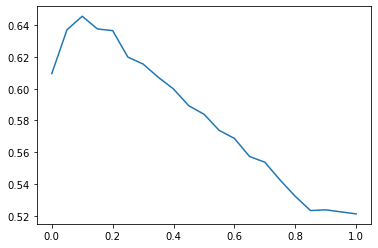

In [ ]:
plt.plot(macro_f1_dict.keys(),macro_f1_dict.values())

**Q:** Comment on the plot. What kind of trends are visible?

**A:** The macro f1 score peaked when alpha = 0.1. Performance deteriorated with subsequent increases in the smoothing parameter

## 4) Multinomial Naive Bayes, Unigrams, Additive Smoothing, Feature Selection
With additive smoothing, we are using all words that appeared in either class as features in our classifier. However, intuitively, not all words will be equally useful for our task of distinguishing between hateful and non-hateful tweets. Some words may be very uninformative, or even just add noise to our classification. For example, "lol" appears 399 times in non-hateful tweets and 21 times a hateful tweets, and we have no clear theoretical reason for why it would be indicative of either hateful or non-hateful content.<br>
Our final improvement to the Naive Bayes classifier will be to have it use only the most informative features. We do not want to rely on intuition to select what those are, so we use mutual information as a metric of informativeness.

#### 4a) Write a function to calculate mutual information
Mutual information is only defined for features (in this case: unigrams) that appear in both classes. For those features that only appear in one class or the other, set mutual information to be 0. Refer to the lecture notes for how to calculate mutual information.

In [ ]:
D_pos = sum(y_train=='hateful')
D_neg = sum(y_train=='non-hateful')
total = D_pos + D_neg

In [ ]:
def word_score(a,b,c,d):
    word_score = (a/total) * math.log2( (total*a) / ((a+c)*(a+b)) ) + (b/total) * math.log2( (total*b) / ((b+d)*(a+b)) ) + (c/total) * math.log2( (total*c) / ((a+c)*(c+d)) ) + (d/total) * math.log2( (total*d) / ((b+d)*(c+d)) )
    return word_score

In [ ]:
df = pd.merge(pd.DataFrame(train_tweets_distinct['hateful'].items(), columns=['word','freq_pos']),
              pd.DataFrame(train_tweets_distinct['non-hateful'].items(), columns=['word','freq_neg']),on='word',how='outer')
df = df.fillna(0)

In [ ]:
df['mutual info'] = df.apply(lambda row: word_score(row.freq_pos, (D_pos-row.freq_pos),row.freq_neg, (D_neg-row.freq_neg)) if row.word in (train_tweets_distinct['hateful'].keys() & train_tweets_distinct['non-hateful'].keys()) else 0, axis=1)

#### 4b) Find most informative features based on Mutual Information
Store all features in a list sorted in descending order by their mutual information and print the top 30 most informative features. Comment on them. Do they match your expectations?

In [ ]:
df = df.sort_values('mutual info', ascending=False)
df.head(30)

,word,freq_pos,freq_neg,mutual info
73,nigga,289.0,159.0,0.014536
57,hate,403.0,764.0,0.012829
84,niggas,238.0,113.0,0.012362
95,idiot,153.0,538.0,0.003119
26,trump,174.0,1029.0,0.002077
256,mad,94.0,374.0,0.001705
451,hell,97.0,469.0,0.001450
181,ugly,83.0,356.0,0.001400
576,racist,34.0,36.0,0.001360
286,idiots,73.0,297.0,0.001293


In [ ]:
most_informative = df.word.values

**A:** Informative features include words with connotations that can be hateful depending on context (e.g. n word, bitch) and words referring to populations that are often the targets of hate speech (females, muslim).

#### 4a) Find the optimal number of features
We now want to tune the number of most-informative features as a hyperparameter. Use the optimal smoothing parameter you found before. If you did not complete the earlier question, use smoothing_alpha = 0.1. (Note that it is not guaranteed that the best smoothing parameter you found earlier is still optimal for any choice of top_n. We stick with the best smoothing parameter we found earlier to simplify things.)

In [ ]:
top_ns = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]

In [ ]:
%%time
y_preds={}
for n in top_ns:
    prob_pos_smooth, prob_neg_smooth = calculate_proba(smoothing=True, alpha=0.1, trim = True, n=n)
    y_pred = [predict_text(x, prob_pos_smooth, prob_neg_smooth, smoothing=True, alpha=alpha) for x in X_dev]
    y_preds[n]=y_pred

macro_f1_dict = dict()

Wall time: 6.68 s


Find the best and worst values for N, and their corresponding macro F1 scores. Comment briefly on the results, comparing them to your results from when you were using additive smoothing without feature selection.

In [ ]:
for n in top_ns:
    macro_f1_dict[n] = f1_score(y_dev, y_preds[n], average='macro')

In [ ]:
print(f'{min(macro_f1_dict,key=macro_f1_dict.get)}: {macro_f1_dict[min(macro_f1_dict,key=macro_f1_dict.get)]}')
print(f'{max(macro_f1_dict,key=macro_f1_dict.get)}: {macro_f1_dict[max(macro_f1_dict,key=macro_f1_dict.get)]}')

1: 0.5573942194709003
200: 0.6643124352454544


**A:** The naive bayes model with smoothing (alpha = 0.1) and feature selection (n = 200) outperformed the model with smoothing (0.64), getting a macro f1 of 0.66 on the dev set.

#### 4b) Visualise the results and comment
Create a matplotlib line plot that shows the macro F1 score (y-axis) for the different numbers of most-informative features (x-axis). You may want to use a log-scale for the x-axis.

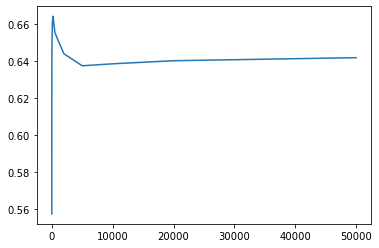

In [ ]:
plt.plot(macro_f1_dict.keys(),macro_f1_dict.values())

**Q:** Comment on the plot. What kind of trends are visible?

**A:** The f1 score spiked when n = 200. Afterward, the f1 score went down and stabilized around 0.64. We can observe very marginal increase in macro f1 as we increase the number of features. However, it doesn't reach our max f1.

## 5) Error Analysis
We have built a Naive Bayes classifier from scratch using pure Python, and we improved it by adding additive smoothing and feature selection based on mutual information. The end result is a classifier that still does not perform great, but it is a useful baseline that we understand well.<br>
At this final stage, it is good practice to manually inspect some of the errors made by our classifier, to create hypotheses about its weaknesses, so we can address them in future work. You will see this kind of analysis in many research articles.

#### 5a) Train and evaluate our best classifier so far
Using your findings from above, train the classifier that performed best on the dev set. Get its predictions on the test set and print a classification report. If you could not make additive smoothing and/or feature selection work, use the simplest implementation of Naive Bayes that did work for you.

In [ ]:
prob_pos_smooth, prob_neg_smooth = calculate_proba(smoothing=True, alpha=0.1, trim = True, n=200)
y_pred = [predict_text(x, prob_pos_smooth, prob_neg_smooth, smoothing=True, alpha=alpha) for x in X_test]
print(confusion_matrix(y_test, y_pred, labels = ['hateful', 'non-hateful']))
print(classification_report(y_test, y_pred, labels = ['hateful', 'non-hateful']))

[[  232   406]
 [  329 12132]]
              precision    recall  f1-score   support

     hateful       0.41      0.36      0.39       638
 non-hateful       0.97      0.97      0.97     12461

    accuracy                           0.94     13099
   macro avg       0.69      0.67      0.68     13099
weighted avg       0.94      0.94      0.94     13099



#### 5b) Inspect false positives
We are interested in detecting hateful tweets, so "hateful" is our positive class and "non-hateful" our negative class.<br>
Print and inspect a sample of 10 tweets that were falsely predicted to be "hateful".

In [ ]:
mask=[]
for x,y in zip([y == 'non-hateful' for y in y_test], [y == 'hateful' for y in y_pred]):
    mask.append((x==y==True))
X_test[mask][0:10]

array([list(['usr', 'as', 'said', 'mans', 'levels', 'nd', 'haters', 'gon', 'hate', 'same', 'thing', 'think', 'bout', 'you', 'so', 'you', 'can', 'keep', 'on', 'chatting', 'bar', 'url']),
       list(['usr', 'but', 'usr', 'are', 'better', 'than', 'the', 'republicans', 'because', 'uh', 'some', 'of', 'us', 'like', 'the', 'gays', 'only', 'bill', 'url']),
       list(['rt', 'usr', 'why', 'hate', 'louisiana', 'niggas', 'url']),
       list(['rt', 'usr', 'always', 'ugly', 'to', 'bitch', 'that', 'don', 'like', 'me', 'always', 'scary', 'to', 'bitch', 'that', 'won', 'fight', 'me', 'just', 'that', 'bitch']),
       list(['mikepence', 'not', 'being', 'able', 'to', 'have', 'dinner', 'alone', 'with', 'any', 'woman', 'other', 'than', 'his', 'wife', 'etc', 'is', 'just', 'like', 'being', 'strict', 'muslim', 'ironic']),
       list(['usr', 'my', 'worst', 'experience', 'with', 'red', 'light', 'triggers', 'one', 'idiot', 'stopped', 'in', 'front', 'of', 'it', 'other', 'idiot', 'stopped', 'be', 'url']),
    

**Q:** Comment on these errors. Can you spot any patterns and think of potential explanations for why these tweets were falsely predicted to be "hateful"?

The model cannot predict the slang usage of words like bitch. It is also possible that words refering to sensitive populations that are often targeted by hate speech (e.g. muslims) often appear in hate speech in the dataset, hence, the model is not able to nuance between differing uses of the word.

#### 5c) Inspect false negatives
Print and inspect a sample of 15 tweets that were falsely predicted to be "non-hateful".

In [ ]:
mask=[]
for x,y in zip([y == 'hateful' for y in y_test], [y == 'non-hateful' for y in y_pred]):
    mask.append((x==y==True))
X_test[mask][0:15]

array([list(['usr', 'usr', 'thought', 'gop', 'trump', 'want', 'everything', 'decided', 'locally', 'or', 'by', 'the', 'states', 'dangerous', 'hypocrites']),
       list(['hillary', 'scott', 'is', 'filthy', 'fuckin', 'fuck', 'pig', 'url']),
       list(['psychiatrists', 'appear', 'addicted', 'to', 'the', 'pain', 'suffering', 'they', 'cause', 'people', 'url']),
       list(['happy', '18th', 'to', 'the', 'meanest', 'sassiest', 'and', 'rudest', 'person', 'know', 'so', 'glad', 'we', 'became', 'friends', 'after', 'you', 'slapped', 'me', 'in', 'the', 'url']),
       list(['usr', 'that', 'reminds', 'me', 'need', 'to', 'pick', 'up', 'one', 'of', 'those', 'fake', 'headrest', 'switch', 'mounts', 'before', 'deluxe', 'hits', 'so', 'that', 'url']),
       list(['usr', 'usr', 'stupid', 'fucking', 'leftists', 'can', 'understand', 'why', 'labor', 'organizer', 'is', 'opposed', 'to', 'illegal', 'im', 'url']),
       list(['usr', 'usr', 'usr', 'usr', 'usr', 'is', 'this', 'what', 'happens', 'when', 'you', '

**Q:** Comment on these errors. Can you spot any patterns and think of potential explanations for why these tweets were falsely predicted to be "non-hateful"?

**A:** The words were possibly falsely predicted as non-hateful because they contain a lot of words that aren't necessarily offensive but can be used in an offensive manner.